## Task

Come up with a definition for a viral video, videos with view counts that are trending up.

#### Viral in the context of a front page video, the video should:
1. Have significant daily views
2. Is likely to appeal to more users
3. Are strickly growing in popularity

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
# Load in data
video_count = pd.read_csv('video_count.csv')
video_features = pd.read_csv('video_features.csv')

In [4]:
print(video_count.describe(), '\n')
print(video_features.apply(lambda x: x.nunique(), axis=0))

           video_id         count
count  41775.000000  4.177500e+04
mean    1498.673250  6.243710e+05
std      864.094856  8.879097e+05
min        1.000000  1.000000e+00
25%      754.000000  9.095500e+03
50%     1492.000000  1.795580e+05
75%     2236.000000  9.043615e+05
max     3000.000000  6.070570e+06 

video_id             2785
video_length         1037
video_language          6
video_upload_date      23
video_quality           5
dtype: int64


We can probably eliminate the videos that have never been popular for a particular day in our timeframe. While this is largely arbitrary, our main purpose is to remove videos that do not have mass appeal.

In [68]:
# Keeping only videos who were in the top 25% most popular videos for that day at least once
temp = pd.merge(left=video_count, right=video_count.groupby('date', as_index=False).agg({'count': 'sum'}), on='date')
temp.count_x = temp.count_x / temp.count_y
temp = temp.drop('count_y', axis=1).rename(columns = {'count_x': 'percent_views'})

popular = set(temp.loc[temp['percent_views'] > 5.098088e-04, 'video_id'].tolist())
videos = temp[temp.video_id.isin(popular)]

Let's figure out what type of video is more likely to be popular and filter further down our dataset. 

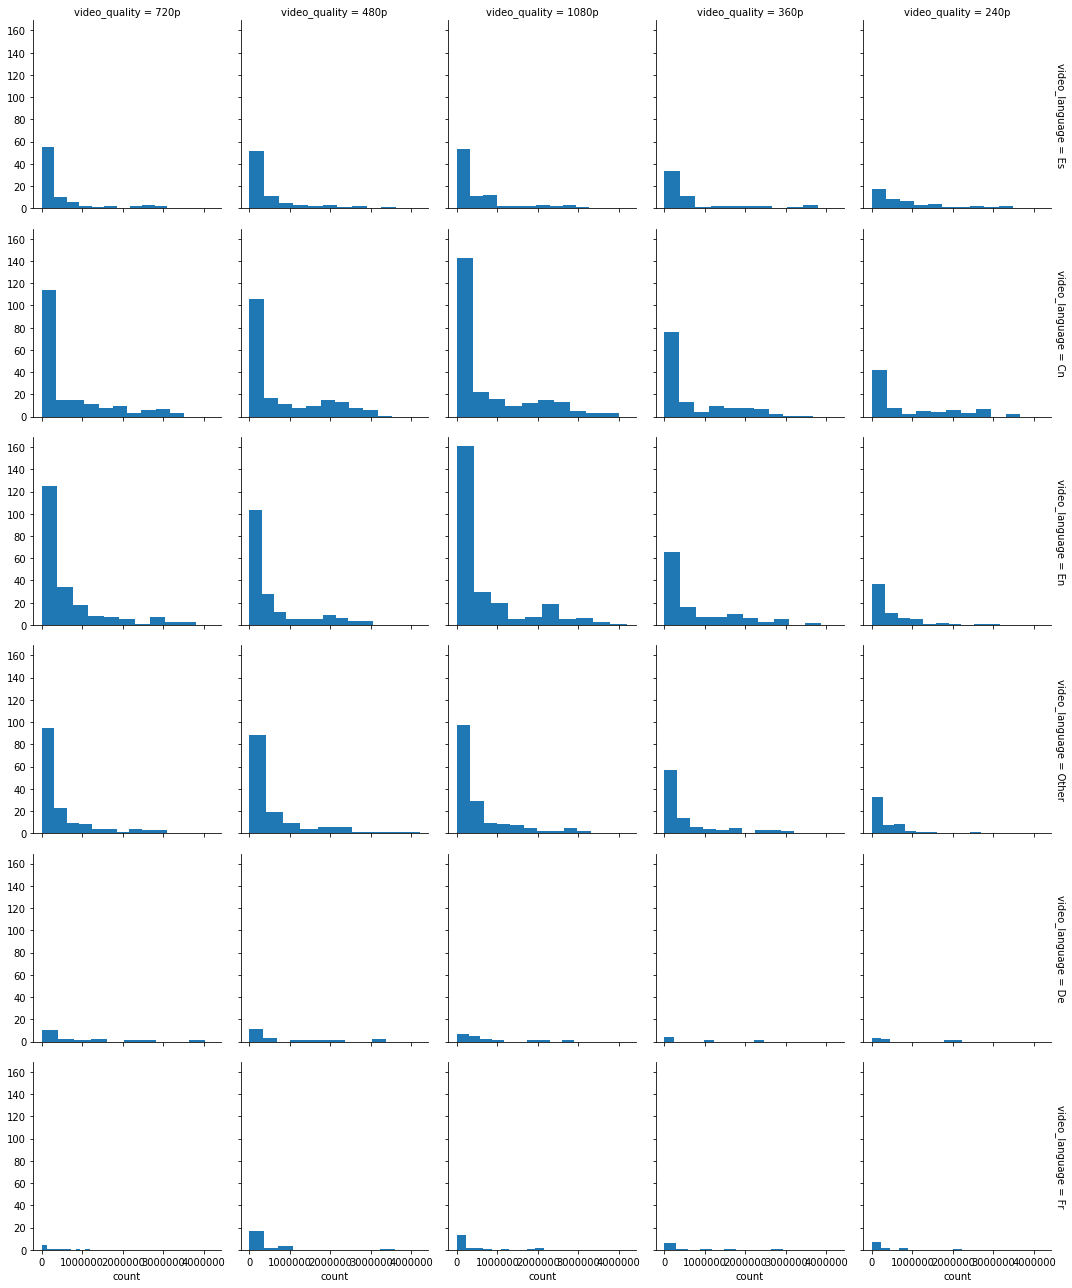

In [51]:
# Visualise effects of language and quality in videos
temp = pd.merge(left=video_count.groupby('video_id', as_index=False).agg({'count': 'mean'}), right=video_features, on='video_id')
g = sns.FacetGrid(temp, col='video_quality',  row='video_language', margin_titles=True)
g = g.map(plt.hist, 'count')

Two take-aways:
1. There are not a lot of content creators in Fr, De, or other language and those languages tend not to have high average daily views.
2. Video quality doesn't seem to have an effect on average daily views when accounting for number of videos in each category. 

Because we are looking for videos to put in front of all visitors, we should restrict our videos to videos in En, Cn, or Es.

In [69]:
videos = pd.merge(left=videos, right=video_features, on='video_id')
videos = videos[videos['video_language'].isin(['Cn', 'Es', 'En'])]

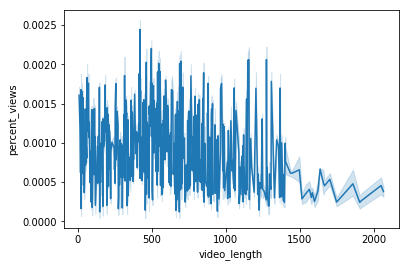

In [57]:
# Looking into video length
plt.show(sns.lineplot('video_length', 'percent_views', data=videos))

There seems to be a general peak in percent views for videos around 500 seconds but the trend is not significant enough to discard any videos smaller than 1450 seconds.

In [70]:
videos = videos[videos.video_length < 1450]

Let's take a look at video_upload_date.

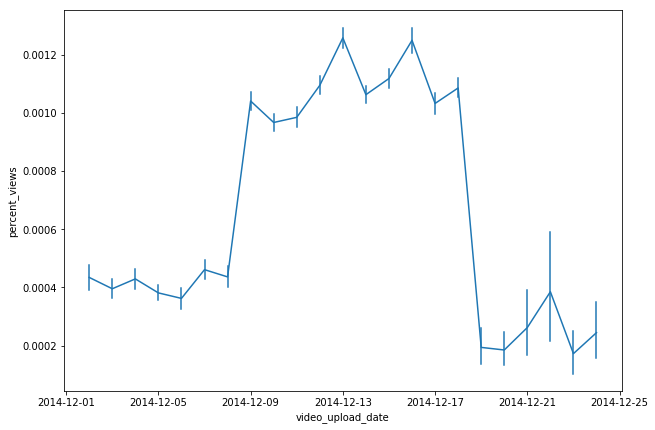

In [71]:
videos['video_upload_date'] = pd.to_datetime(videos['video_upload_date'], infer_datetime_format=True)
fig = plt.figure(figsize=(10,7))
plt.show(sns.lineplot(videos['video_upload_date'], videos['percent_views'], err_style="bars"))

There seems to be a significant upshot for days between 2014-12-10 and 2014-12-18. This isn't easily explainable, especially since the time interval for percent_views is between 2015-01-01 and 2015-01-15. This could be due to business decisions such as marketing or a surge of activity by popular content creators. At the risk of overfitting, we will include these findings in our definition of viral assuming this is a constant phenomenon.

In [73]:
videos = videos[(videos.video_upload_date > '2014-09-10') & (videos.video_upload_date > '2014-09-18')]

698

### The videos selected can be expected to be well received by the public according to the variables available.

In [77]:
# Setting index and ordering
videos = videos.set_index(['video_id', 'date']).sort_index()
videos.head()

percent_views  video_length video_language  \
video_id date                                                     
2        2015-01-01       0.000963           751             Cn   
         2015-01-02       0.000921           751             Cn   
         2015-01-03       0.000917           751             Cn   
         2015-01-04       0.000906           751             Cn   
         2015-01-05       0.001003           751             Cn   

                    video_upload_date video_quality  
video_id date                                        
2        2015-01-01        2014-12-14          480p  
         2015-01-02        2014-12-14          480p  
         2015-01-03        2014-12-14          480p  
         2015-01-04        2014-12-14          480p  
         2015-01-05        2014-12-14          480p

At this point, we videos that are strictly growing in popularity.

In [127]:
# Looking at growth over time
growth = videos['percent_views']
growth = growth.to_frame().join(growth.groupby(level='video_id').shift(1).rename('lag'))
growth['growth'] = (growth.percent_views/growth.lag)*100

# Filter for strickly growing videos
growing = set(growth[growth['growth'] < 100].index.get_level_values(0).tolist())
growth = growth.reset_index(1)
viral = set(growth[~growth.index.isin(growing)].index.tolist())

In [131]:
# Showcase viral videos by video_id
print('We have determined {} videos are viral: '.format(len(viral)), viral)

We have determined 33 videos are viral:  {2310, 2438, 270, 527, 144, 401, 660, 1940, 926, 2590, 1440, 2086, 1706, 1451, 1962, 1456, 2737, 2099, 2485, 186, 1853, 2368, 2759, 1483, 2004, 2526, 353, 2151, 2794, 2540, 2804, 247, 511}
{2310, 2438, 270, 527, 144, 401, 660, 1940, 926, 2590, 1440, 2086, 1706, 1451, 1962, 1456, 2737, 2099, 2485, 186, 1853, 2368, 2759, 1483, 2004, 2526, 353, 2151, 2794, 2540, 2804, 247, 511}
